## Statistical Tests of Experimental Results

In [8]:
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from statsmodels.stats.contingency_tables import mcnemar

In [9]:
def compare_f1_scores(df1, df2, n_bootstrap=10000, alpha=0.05):
    """
    Compare F1 scores between two conditions using both McNemar's test and bootstrap
    
    Parameters:
    df1, df2: DataFrames containing 'classification' and 'prediction' columns
    n_bootstrap: Number of bootstrap iterations
    alpha: Significance level
    
    Returns:
    dict with test results
    """
    print("Calculating original F1 scores...")
    # Calculate original F1 scores
    f1_1 = f1_score(df1['classification'], df1['prediction'], average='macro')
    f1_2 = f1_score(df2['classification'], df2['prediction'], average='macro')
    
    print("Creating contingency table...")
    # Create contingency table for McNemar's test
    correct1 = df1['classification'] == df1['prediction']
    correct2 = df2['classification'] == df2['prediction']
    
    both_correct = sum((correct1) & (correct2))
    both_wrong = sum((~correct1) & (~correct2))
    only1_correct = sum((correct1) & (~correct2))
    only2_correct = sum((~correct1) & (correct2))
    
    contingency = np.array([[both_correct, only1_correct],
                           [only2_correct, both_wrong]])
    
    print("Performing McNemar's test...")
    # Perform McNemar's test
    mcnemar_result = mcnemar(contingency, exact=True, correction=True)
    
    print("Performing bootstrap test...")
    # Bootstrap test
    n_samples = len(df1)
    f1_diffs = []
    
    for i in range(n_bootstrap):
        if i % 1000 == 0:  # Progress update every 1000 iterations
            print(f"Bootstrap iteration {i}/{n_bootstrap}")
            
        # Sample with replacement
        indices = np.random.randint(0, n_samples, n_samples)
        
        # Calculate F1 scores for this bootstrap sample
        f1_1_boot = f1_score(df1['classification'].iloc[indices], 
                            df1['prediction'].iloc[indices], 
                            average='macro')
        f1_2_boot = f1_score(df2['classification'].iloc[indices], 
                            df2['prediction'].iloc[indices], 
                            average='macro')
        
        f1_diffs.append(f1_1_boot - f1_2_boot)
    
    print("Calculating confidence intervals and p-values...")
    # Calculate confidence interval
    ci_lower = np.percentile(f1_diffs, alpha/2 * 100)
    ci_upper = np.percentile(f1_diffs, (1-alpha/2) * 100)
    
    # Calculate bootstrap p-value
    # H0: difference = 0
    bootstrap_p = min(
        sum(f1_diff <= 0 for f1_diff in f1_diffs),
        sum(f1_diff >= 0 for f1_diff in f1_diffs)
    ) / n_bootstrap * 2  # multiply by 2 for two-tailed test
    
    results = {
        'f1_score_1': f1_1,
        'f1_score_2': f1_2,
        'f1_difference': f1_1 - f1_2,
        'contingency_table': contingency.tolist(),
        'mcnemar_statistic': float(mcnemar_result.statistic),
        'mcnemar_p_value': float(mcnemar_result.pvalue),
        'bootstrap_p_value': bootstrap_p,
        'bootstrap_ci': (ci_lower, ci_upper),
        'significant_mcnemar': mcnemar_result.pvalue < alpha,
        'significant_bootstrap': bootstrap_p < alpha
    }
    
    print("\nResults Summary:")
    print(f"F1 Score Model 1: {f1_1:.4f}")
    print(f"F1 Score Model 2: {f1_2:.4f}")
    print(f"Difference: {f1_1 - f1_2:.4f}")
    print(f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})")
    print(f"McNemar's test p-value: {mcnemar_result.pvalue:.4f}")
    print(f"Bootstrap test p-value: {bootstrap_p:.4f}")
    print("\nContingency Table:")
    print("Both correct:", contingency[0,0])
    print("Only Model 1 correct:", contingency[0,1])
    print("Only Model 2 correct:", contingency[1,0])
    print("Both wrong:", contingency[1,1])
    
    return results

# Example usage:
"""
results = compare_f1_scores(
    condition1_results_df,
    condition2_results_df,
    n_bootstrap=10000,
    alpha=0.05
)

print(f"F1 Score Difference: {results['f1_difference']:.4f}")
print(f"95% CI: ({results['bootstrap_ci'][0]:.4f}, {results['bootstrap_ci'][1]:.4f})")
print(f"McNemar's test p-value: {results['mcnemar_p_value']:.4f}")
print(f"Bootstrap test p-value: {results['bootstrap_p_value']:.4f}")
"""

'\nresults = compare_f1_scores(\n    condition1_results_df,\n    condition2_results_df,\n    n_bootstrap=10000,\n    alpha=0.05\n)\n\nprint(f"F1 Score Difference: {results[\'f1_difference\']:.4f}")\nprint(f"95% CI: ({results[\'bootstrap_ci\'][0]:.4f}, {results[\'bootstrap_ci\'][1]:.4f})")\nprint(f"McNemar\'s test p-value: {results[\'mcnemar_p_value\']:.4f}")\nprint(f"Bootstrap test p-value: {results[\'bootstrap_p_value\']:.4f}")\n'

In [3]:
# Load the CSV file as a dataframe: 'research/B3-G4OM_results.csv'
b3_g4om_results_df = pd.read_csv('research/B3-G4OM_results.csv')

In [4]:
b3_g4om_results_df.head()

,review,classification,prediction,match,source
0,I had called in advance to see if they offered...,positive,positive,True,dynasent_r1
1,EVERY SINGLE ITEM WAS INEDIBLE.,negative,negative,True,dynasent_r1
2,Rooms are small.,negative,negative,True,dynasent_r1
3,"Without resorting to hyperbole , I can state t...",positive,positive,True,sst_local
4,Used a $12 Groupon deal (to cover $20 meal).,neutral,neutral,True,dynasent_r1


In [5]:
e3_g4om_ebft_results_df = pd.read_csv('research/E3-G4OM-EBFT_results.csv')

In [6]:
e3_g4om_ebft_results_df.head()

,review,classification,prediction,match,classifier_decision,probabilities,source
0,I had called in advance to see if they offered...,positive,positive,True,positive,"[0.0067187948152422905, 0.12026865035295486, 0...",dynasent_r1
1,EVERY SINGLE ITEM WAS INEDIBLE.,negative,negative,True,negative,"[0.9962775111198425, 0.0008909022435545921, 0....",dynasent_r1
2,Rooms are small.,negative,negative,True,negative,"[0.9880671501159668, 0.0057336497120559216, 0....",dynasent_r1
3,"Without resorting to hyperbole , I can state t...",positive,positive,True,positive,"[0.0005525431479327381, 0.00032680953154340386...",sst_local
4,Used a $12 Groupon deal (to cover $20 meal).,neutral,neutral,True,neutral,"[8.027169678825885e-05, 0.9932464361190796, 0....",dynasent_r1


In [10]:
e3_vs_b3_results = compare_f1_scores(
    e3_g4om_ebft_results_df,
    b3_g4om_results_df,
    n_bootstrap=10000,
    alpha=0.05
)

Calculating original F1 scores...
Creating contingency table...
Performing McNemar's test...
Performing bootstrap test...
Bootstrap iteration 0/10000
Bootstrap iteration 1000/10000
Bootstrap iteration 2000/10000
Bootstrap iteration 3000/10000
Bootstrap iteration 4000/10000
Bootstrap iteration 5000/10000
Bootstrap iteration 6000/10000
Bootstrap iteration 7000/10000
Bootstrap iteration 8000/10000
Bootstrap iteration 9000/10000
Calculating confidence intervals and p-values...

Results Summary:
F1 Score Model 1: 0.8274
F1 Score Model 2: 0.7952
Difference: 0.0322
95% CI: (0.0230, 0.0415)
McNemar's test p-value: 0.0000
Bootstrap test p-value: 0.0000

Contingency Table:
Both correct: 4887
Only Model 1 correct: 556
Only Model 2 correct: 359
Both wrong: 728


In [84]:
import numpy as np
import torch
from sklearn.metrics import f1_score
from statsmodels.stats.contingency_tables import mcnemar
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from tqdm import tqdm
import time
from datetime import datetime

# Set the start method to 'spawn' for CUDA compatibility
if __name__ == '__main__':
    multiprocessing.set_start_method('spawn', force=True)

def run_bootstrap_iteration(args):
    """Single bootstrap iteration, GPU-aware"""
    indices, df1, df2, device_id = args
    
    # Set GPU device if available
    if torch.cuda.is_available():
        torch.cuda.set_device(device_id)
    
    # Calculate F1 scores for this bootstrap sample
    f1_1 = f1_score(df1['classification'].iloc[indices], 
                    df1['prediction'].iloc[indices], 
                    average='macro')
    f1_2 = f1_score(df2['classification'].iloc[indices], 
                    df2['prediction'].iloc[indices], 
                    average='macro')
    
    return f1_1 - f1_2

def parallel_bootstrap(df1, df2, n_bootstrap=10000, n_workers=None):
    """Run bootstrap iterations in parallel, CUDA-safe"""
    n_samples = len(df1)
    
    # Generate all random indices beforehand
    all_indices = [np.random.randint(0, n_samples, n_samples) 
                  for _ in range(n_bootstrap)]
    
    # Calculate F1 scores without GPU
    f1_diffs = []
    for indices in tqdm(all_indices, desc="Bootstrap iterations"):
        f1_1 = f1_score(df1['classification'].iloc[indices], 
                        df1['prediction'].iloc[indices], 
                        average='macro')
        f1_2 = f1_score(df2['classification'].iloc[indices], 
                        df2['prediction'].iloc[indices], 
                        average='macro')
        f1_diffs.append(f1_2 - f1_1)  # Always exp2 - exp1
    
    return np.array(f1_diffs)  # Return as numpy array

def check_bootstrap_stability(df1, df2, iterations=[1000, 5000], runs=3):
    """Check stability of bootstrap results"""
    start_time = datetime.now()
    print(f"Starting stability analysis at {start_time}")
    
    results = {}
    
    # Calculate contingency table once
    correct1 = df1['classification'] == df1['prediction']
    correct2 = df2['classification'] == df2['prediction']
    contingency = np.array([
        [sum((correct1) & (correct2)), sum((correct1) & (~correct2))],
        [sum((~correct1) & (correct2)), sum((~correct1) & (~correct2))]
    ])
    
    for n_iter in iterations:
        results[n_iter] = []
        print(f"\nTesting {n_iter} iterations:")
        
        for run in range(runs):
            run_start = datetime.now()
            print(f"\nRun {run + 1}/{runs} started at {run_start}")
            np.random.seed(run)
            
            # Calculate difference consistently as exp2 - exp1
            f1_1 = f1_score(df1['classification'], df1['prediction'], average='macro')
            f1_2 = f1_score(df2['classification'], df2['prediction'], average='macro')
            f1_difference = f1_2 - f1_1  # Always exp2 - exp1
            
            # McNemar's test
            mcnemar_result = mcnemar(contingency, exact=True, correction=True)
            
            # Bootstrap
            bootstrap_samples = parallel_bootstrap(df1, df2, n_bootstrap=n_iter)
            
            # Calculate bootstrap p-value and CI
            alpha = 0.05
            ci_lower = np.percentile(bootstrap_samples, alpha/2 * 100)
            ci_upper = np.percentile(bootstrap_samples, (1-alpha/2) * 100)
            bootstrap_p = min(
                sum(diff <= 0 for diff in bootstrap_samples),
                sum(diff >= 0 for diff in bootstrap_samples)
            ) / n_iter * 2
            
            run_results = {
                'f1_score_1': f1_1,
                'f1_score_2': f1_2,
                'f1_difference': f1_difference,
                'mcnemar_p_value': float(mcnemar_result.pvalue),
                'bootstrap_p_value': bootstrap_p,
                'bootstrap_ci': (ci_lower, ci_upper),
                'contingency_table': contingency.tolist(),
                'bootstrap_samples': bootstrap_samples,  # Save the samples
                'run_time': datetime.now() - run_start
            }
            
            results[n_iter].append(run_results)
            
            # Print run results
            print(f"\nRun {run + 1} Results:")
            print(f"F1 Score 1: {f1_1:.4f}")
            print(f"F1 Score 2: {f1_2:.4f}")
            print(f"F1 Difference: {f1_difference:+.4f}")
            print(f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})")
            print(f"McNemar's p-value: {run_results['mcnemar_p_value']:.4f}")
            print(f"Bootstrap p-value: {bootstrap_p:.4f}")
            print(f"Run time: {run_results['run_time']}")
            print("\nContingency Table:")
            print(f"Both correct: {contingency[0,0]}")
            print(f"Only Model 1 correct: {contingency[0,1]}")
            print(f"Only Model 2 correct: {contingency[1,0]}")
            print(f"Both wrong: {contingency[1,1]}")
    
    return results

# Example paper-ready reporting function
def generate_paper_report(stability_results, exp1_name="Model 1", exp2_name="Model 2"):
    """Generate publication-ready text from stability analysis results"""
    final_iter = max(stability_results.keys())
    final_results = stability_results[final_iter]
    
    # Calculate mean values across runs
    mean_f1_1 = np.mean([r['f1_score_1'] for r in final_results])
    mean_f1_2 = np.mean([r['f1_score_2'] for r in final_results])
    mean_f1_diff = np.mean([r['f1_difference'] for r in final_results])
    mean_mcnemar_p = np.mean([r['mcnemar_p_value'] for r in final_results])
    mean_bootstrap_p = np.mean([r['bootstrap_p_value'] for r in final_results])
    cis = np.array([r['bootstrap_ci'] for r in final_results])
    ci_lower_std = np.std([ci[0] for ci in cis])
    ci_upper_std = np.std([ci[1] for ci in cis])
    
    # Determine statistical significance
    is_significant = mean_mcnemar_p < 0.05 and mean_bootstrap_p < 0.05
    
    # Format p-values
    def format_p_value(p):
        if p < 0.001:
            return "p < 0.001"
        return f"p = {p:.3f}"
    
    mcnemar_p_text = format_p_value(mean_mcnemar_p)
    bootstrap_p_text = format_p_value(mean_bootstrap_p)
    
    # Determine performance relationship and create appropriate text
    if abs(mean_f1_diff) < 1e-10:  # practically zero
        performance_text = (
            f"{exp1_name} and {exp2_name} achieved identical F1 scores of "
            f"{mean_f1_1*100:.2f}%."
        )
    else:
        better_model = exp2_name if mean_f1_2 > mean_f1_1 else exp1_name
        worse_model = exp1_name if mean_f1_2 > mean_f1_1 else exp2_name
        better_score = max(mean_f1_1, mean_f1_2)
        worse_score = min(mean_f1_1, mean_f1_2)
        
        if is_significant:
            performance_text = (
                f"{better_model} significantly outperformed {worse_model} with an F1 score "
                f"of {better_score*100:.2f}% compared to {worse_score*100:.2f}%, "
                f"a difference of {abs(mean_f1_diff)*100:.2f} percentage points."
            )
        else:
            performance_text = (
                f"While {better_model} achieved a nominally higher F1 score "
                f"({better_score*100:.2f}%) compared to {worse_model} ({worse_score*100:.2f}%), "
                f"the difference of {abs(mean_f1_diff)*100:.2f} percentage points was not "
                f"statistically significant."
            )
    
    # Create significance text based on results
    if abs(mean_f1_diff) < 1e-10:
        significance_text = (
            f"Statistical tests were not applicable as the models produced identical results."
        )
    elif is_significant:
        significance_text = (
            f"This difference was statistically significant according to both McNemar's test "
            f"({mcnemar_p_text}) and bootstrap analysis ({bootstrap_p_text}). The 95% confidence "
            f"interval for the difference was [{cis[0][0]*100:.2f}%, {cis[0][1]*100:.2f}%]."
        )
    else:
        significance_text = (
            f"The difference did not reach statistical significance in either McNemar's test "
            f"({mcnemar_p_text}) or bootstrap analysis ({bootstrap_p_text}). The 95% confidence "
            f"interval for the difference was [{cis[0][0]*100:.2f}%, {cis[0][1]*100:.2f}%], "
            f"which includes zero."
        )
    
    report = f"""Statistical Analysis Results

Performance Comparison:
{performance_text}

Statistical Significance:
{significance_text}

Stability Analysis:
The results were assessed across multiple bootstrap runs (n={final_iter}), with 
confidence interval bounds showing minimal variation (SD: {ci_lower_std:.6f} to 
{ci_upper_std:.6f}).

Methodological Details:
Statistical significance was assessed using McNemar's test for paired nominal data 
and a bootstrap analysis with {final_iter} iterations. The stability of the results 
was verified through multiple runs with different random seeds to ensure 
reproducibility of the findings."""

    return report

# Usage example:
"""
# Run stability analysis
stability_results = check_bootstrap_stability(
    df1=condition1_results_df,
    df2=condition2_results_df,
    iterations=[1000, 5000, 10000],
    runs=3
)

# Generate paper-ready report
report = generate_paper_report(stability_results)
print(report)
"""

'\n# Run stability analysis\nstability_results = check_bootstrap_stability(\n    df1=condition1_results_df,\n    df2=condition2_results_df,\n    iterations=[1000, 5000, 10000],\n    runs=3\n)\n\n# Generate paper-ready report\nreport = generate_paper_report(stability_results)\nprint(report)\n'

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_statistical_results(results_dict, save_path=None):
    """
    Create publication-quality figure with multiple subplots.
    Uses experiment names from results_dict.
    """
    # Create figure
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. F1 Score Comparison
    models = [results_dict['exp1_name'], results_dict['exp2_name']]
    f1_scores = [results_dict['f1_score_1']*100, results_dict['f1_score_2']*100]
    
    bars = ax1.bar(models, f1_scores, color=['#2ecc71', '#3498db'])
    ax1.grid(True, axis='y')  # Only horizontal grid lines
    ax1.grid(False, axis='x')  # No vertical grid lines
    
    # Add value labels on bars (only once)
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom')
    
    ax1.set_ylabel('F1 Score (%)')
    ax1.set_title('Model Performance Comparison')
    
    # 2. Contingency Table Heatmap
    contingency = np.array(results_dict['contingency_table'])
    sns.heatmap(contingency, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Correct', 'Incorrect'],
                yticklabels=['Correct', 'Incorrect'],
                ax=ax2)
    ax2.set_title('Model Agreement Analysis')
    ax2.set_xlabel(results_dict['exp2_name'])
    ax2.set_ylabel(results_dict['exp1_name'])
    
    # 3. Bootstrap Distribution
    bootstrap_diffs = np.array(results_dict['bootstrap_samples']) * 100
    sns.histplot(data=bootstrap_diffs, kde=True, ax=ax3)
    mean_diff = np.mean(bootstrap_diffs)

    # Flip the sign if needed to show improvement as positive
    if mean_diff < 0:
        bootstrap_diffs = -bootstrap_diffs
        ci_low, ci_high = results_dict['bootstrap_ci']
        ci_low, ci_high = -ci_high*100, -ci_low*100  # Flip and convert to percentage
    else:
        ci_low, ci_high = results_dict['bootstrap_ci']
        ci_low, ci_high = ci_low*100, ci_high*100  # Convert to percentage
    
    ax3.axvline(x=mean_diff, color='r', linestyle='--', 
                label=f'Mean Difference\n({mean_diff:.2f}%)')
    ax3.axvline(x=ci_low, color='g', linestyle=':', 
                label=f'95% CI\n({ci_low:.2f}%, {ci_high:.2f}%)')
    ax3.axvline(x=ci_high, color='g', linestyle=':')
    
    ax3.set_title('Bootstrap Distribution of F1 Score Difference')
    ax3.set_xlabel('F1 Score Difference (%)')
    ax3.set_ylabel('Count')
    ax3.grid(False)
    ax3.legend()
    
    # 4. Error Distribution
    total = np.sum(contingency)
    both_correct = contingency[0,0]
    only_1_correct = contingency[0,1]
    only_2_correct = contingency[1,0]
    both_wrong = contingency[1,1]
    
    error_data = [
        both_correct/total * 100,
        only_1_correct/total * 100,
        only_2_correct/total * 100,
        both_wrong/total * 100
    ]
    labels = [
        'Both\nCorrect',
        f'Only\n{results_dict["exp1_name"]}',
        f'Only\n{results_dict["exp2_name"]}',
        'Both\nWrong'
    ]
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#95a5a6']
    
    ax4.pie(error_data, labels=labels, colors=colors, autopct='%1.1f%%')
    ax4.set_title('Error Distribution')
    
    # Adjust layout and save/show
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [62]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
from typing import Dict, Tuple
import json


def convert_for_json(obj):
    """Convert non-JSON-serializable types to JSON-serializable types"""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, timedelta):
        return str(obj)  # Convert timedelta to string
    elif isinstance(obj, dict):
        return {k: convert_for_json(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_for_json(item) for item in obj]
    return obj

def compare_experiments(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    exp1_name: str,
    exp2_name: str,
    n_bootstrap: int = 5000,
    n_stability_runs: int = 3,
    alpha: float = 0.05,
    save_dir: str = 'experiment_comparisons',
    save_results: bool = True,
    generate_report: bool = True,
    plot_charts: bool = True
) -> Dict:
    """
    Comprehensive statistical comparison of two experiments.
    
    Parameters:
    -----------
    df1, df2 : pd.DataFrame
        DataFrames containing 'classification' and 'prediction' columns
    exp1_name, exp2_name : str
        Names of the experiments for reporting
    n_bootstrap : int
        Number of bootstrap iterations (default: 5000)
    n_stability_runs : int
        Number of stability check runs (default: 3)
    alpha : float
        Significance level (default: 0.05)
    save_dir : str
        Directory to save results (default: 'experiment_comparisons')
    save_results : bool
        Whether to save results to files (default: True)
    
    Returns:
    --------
    Dict containing all results and file paths
    """
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    print(f"\n{'='*80}")
    print(f"Comparing {exp1_name} vs {exp2_name}")
    print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"{'='*80}")
    
    # Create save directory if needed
    if save_results:
        save_path = os.path.join(save_dir, f"{exp1_name}_vs_{exp2_name}", timestamp)
        os.makedirs(save_path, exist_ok=True)
    
    # Run stability analysis (which includes bootstrap)
    print("\nRunning statistical analysis with stability check...")
    stability_results = check_bootstrap_stability(
        df1=df1,
        df2=df2,
        iterations=[n_bootstrap],  # Only run the specified number of iterations
        runs=n_stability_runs
    )
    
    # Get the results from the stability analysis
    first_run_results = stability_results[n_bootstrap][0]  # Use first run for basic results
    
    # Generate report
    if generate_report:
        print("\nGenerating report...")
        report = generate_paper_report(
            stability_results,
            exp1_name=exp1_name,
            exp2_name=exp2_name
        )
    
    # Create visualization
    if plot_charts:
        print("\nCreating visualizations...")
        visualization_results = {
            'f1_score_1': first_run_results['f1_score_1'],
            'f1_score_2': first_run_results['f1_score_2'],
            'f1_difference': first_run_results['f1_difference'],
            'bootstrap_ci': first_run_results['bootstrap_ci'],
            'contingency_table': first_run_results['contingency_table'],
            'bootstrap_samples': first_run_results['bootstrap_samples'],  # Add bootstrap samples
            'exp1_name': exp1_name,
            'exp2_name': exp2_name
        }
    
    if save_results:
        try:
            # Save report
            report_path = os.path.join(save_path, 'statistical_report.txt')
            with open(report_path, 'w') as f:
                f.write(report)
            
            # Save visualization
            viz_path = os.path.join(save_path, 'statistical_analysis.png')
            plot_statistical_results(visualization_results, save_path=viz_path)
            
            # Save raw results, excluding large arrays
            results_path = os.path.join(save_path, 'raw_results.json')
            with open(results_path, 'w') as f:
                json_results = {
                    'first_run_results': convert_for_json({
                        k: v for k, v in first_run_results.items()
                        if k != 'bootstrap_samples'
                    }),
                    'stability_results': convert_for_json({
                        k: [{kk: vv for kk, vv in run.items() 
                            if kk != 'bootstrap_samples'}
                           for run in runs]
                        for k, runs in stability_results.items()
                    })
                }
                json.dump(json_results, f, indent=2)
        except Exception as e:
            print(f"Warning: Could not save results to JSON: {str(e)}")
            print("Continuing with analysis...")

    if plot_charts and not save_results:
        # Just display the visualization
        plot_statistical_results(visualization_results)
    
    # Print final summary
    print("\nResults Summary:")
    print("-" * 40)
    print(f"F1 Score {exp1_name}: {first_run_results['f1_score_1']*100:.2f}%")
    print(f"F1 Score {exp2_name}: {first_run_results['f1_score_2']*100:.2f}%")
    print(f"Difference: {first_run_results['f1_difference']*100:+.2f}%")
    print(f"95% CI: ({first_run_results['bootstrap_ci'][0]*100:.2f}%, {first_run_results['bootstrap_ci'][1]*100:.2f}%)")
    print(f"McNemar's test p-value: {first_run_results['mcnemar_p_value']:.4f}")
    print(f"Bootstrap test p-value: {first_run_results['bootstrap_p_value']:.4f}")
    if generate_report:
        print("\n" + report)
    print("-" * 40)
    
    return {
        'results': first_run_results,
        'stability_results': stability_results,
        'report': report if generate_report else None,
        'save_path': save_path if save_results else None
    }


# Example usage:
"""
# Compare two experiments
results = compare_experiments(
    df1=baseline_results_df,
    df2=experimental_results_df,
    exp1_name='Baseline',
    exp2_name='ELECTRA-Enhanced',
    n_bootstrap=5000,
    save_results=True
)

# Access specific results
print(results['report'])  # Print the paper-ready report
print(f"Results saved to: {results['save_path']}")
"""

'\n# Compare two experiments\nresults = compare_experiments(\n    df1=baseline_results_df,\n    df2=experimental_results_df,\n    exp1_name=\'Baseline\',\n    exp2_name=\'ELECTRA-Enhanced\',\n    n_bootstrap=5000,\n    save_results=True\n)\n\n# Access specific results\nprint(results[\'report\'])  # Print the paper-ready report\nprint(f"Results saved to: {results[\'save_path\']}")\n'

## E3-G4OM-EBFT vs. B3-G4OM

GPT-4o-mini with ELECTRA Base FT predictions vs. GPT-4o-mini baseline.


Comparing B3-G4OM vs E3-G4OM-EBFT
Started at: 2024-11-01 06:59:44

Running statistical analysis with stability check...
Starting stability analysis at 2024-11-01 06:59:44.491674

Testing 10000 iterations:

Run 1/3 started at 2024-11-01 06:59:44.495145


Bootstrap iterations: 100%|██████████| 10000/10000 [09:23<00:00, 17.74it/s]



Run 1 Results:
F1 Score 1: 0.7952
F1 Score 2: 0.8274
F1 Difference: +0.0322
95% CI: (0.0230, 0.0417)
McNemar's p-value: 0.0000
Bootstrap p-value: 0.0000
Run time: 0:09:24.430340

Contingency Table:
Both correct: 4887
Only Model 1 correct: 359
Only Model 2 correct: 556
Both wrong: 728

Run 2/3 started at 2024-11-01 07:09:08.925563


Bootstrap iterations: 100%|██████████| 10000/10000 [09:26<00:00, 17.66it/s]



Run 2 Results:
F1 Score 1: 0.7952
F1 Score 2: 0.8274
F1 Difference: +0.0322
95% CI: (0.0226, 0.0416)
McNemar's p-value: 0.0000
Bootstrap p-value: 0.0000
Run time: 0:09:26.731867

Contingency Table:
Both correct: 4887
Only Model 1 correct: 359
Only Model 2 correct: 556
Both wrong: 728

Run 3/3 started at 2024-11-01 07:18:35.657508


Bootstrap iterations: 100%|██████████| 10000/10000 [09:23<00:00, 17.76it/s]



Run 3 Results:
F1 Score 1: 0.7952
F1 Score 2: 0.8274
F1 Difference: +0.0322
95% CI: (0.0227, 0.0416)
McNemar's p-value: 0.0000
Bootstrap p-value: 0.0000
Run time: 0:09:23.565389

Contingency Table:
Both correct: 4887
Only Model 1 correct: 359
Only Model 2 correct: 556
Both wrong: 728

Generating report...

Creating visualizations...


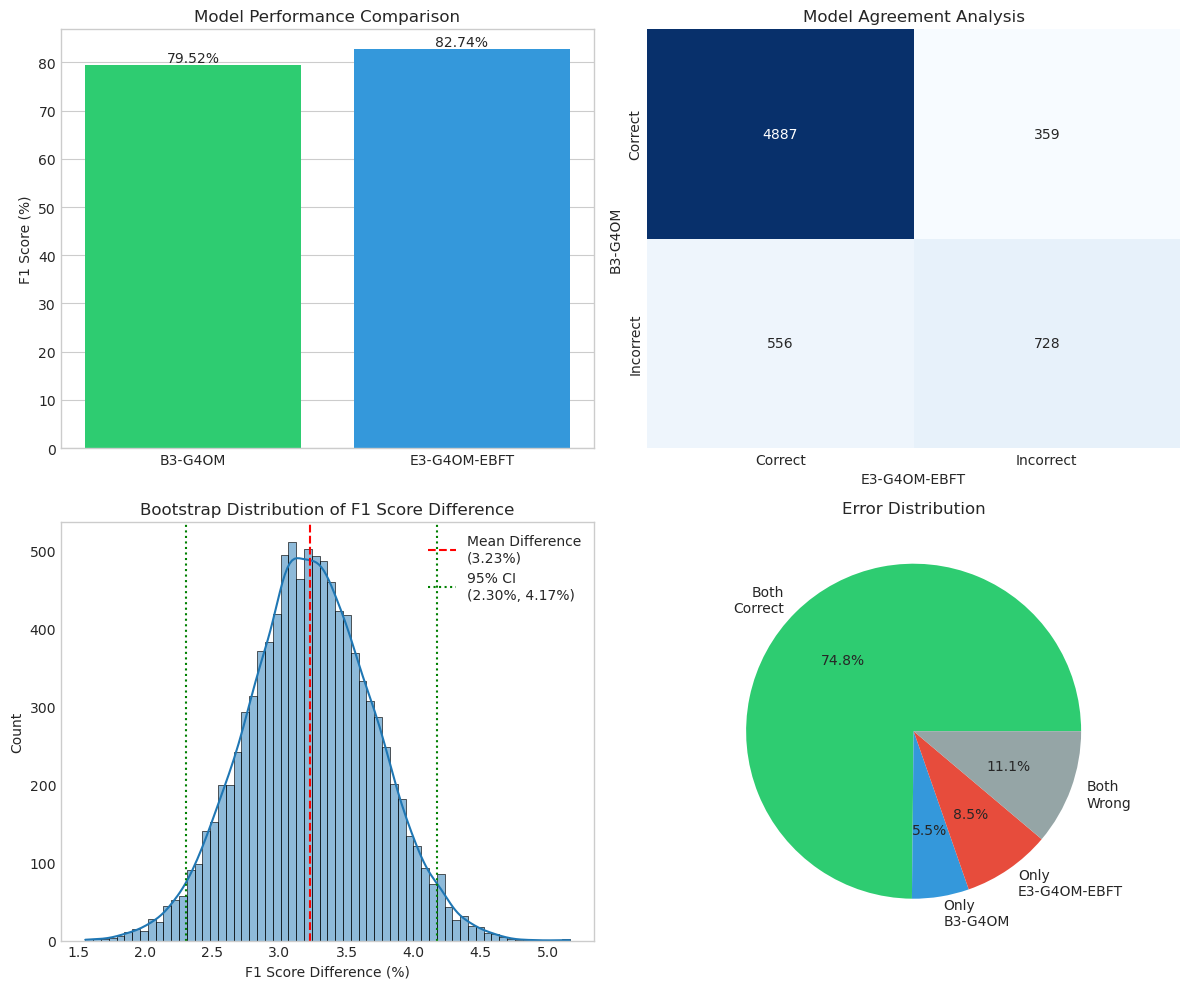


Results Summary:
----------------------------------------
F1 Score B3-G4OM: 79.52%
F1 Score E3-G4OM-EBFT: 82.74%
Difference: +3.22%
95% CI: (2.30%, 4.17%)
McNemar's test p-value: 0.0000
Bootstrap test p-value: 0.0000

Statistical Analysis Results

Performance Comparison:
E3-G4OM-EBFT significantly outperformed B3-G4OM with an F1 score of 82.74% compared to 79.52%, a difference of 3.22 percentage points.

Statistical Significance:
This difference was statistically significant according to both McNemar's test (p < 0.001) and bootstrap analysis (p < 0.001). The 95% confidence interval for the difference was [2.30%, 4.17%].

Stability Analysis:
The results were assessed across multiple bootstrap runs (n=10000), with 
confidence interval bounds showing minimal variation (SD: 0.000164 to 
0.000055).

Methodological Details:
Statistical significance was assessed using McNemar's test for paired nominal data 
and a bootstrap analysis with 10000 iterations. The stability of the results 
was ver

In [87]:
test_results = compare_experiments(
    df1=b3_g4om_results_df,
    df2=e3_g4om_ebft_results_df,
    exp1_name='B3-G4OM',
    exp2_name='E3-G4OM-EBFT',
    n_bootstrap=10000,
    n_stability_runs=3,
)

## E13-G4OM-ELFT vs. B3-G4OM

GPT-4o-mini with ELECTRA Large FT predictions vs. GPT-4o-mini baseline.

In [88]:
# Load the CSV file as a dataframe: 'research/B3-G4OM_results.csv'
e13_g4om_elft_results_df = pd.read_csv('research/E13-G4OM-ELFT_results.csv')


Comparing B3-G4OM vs E13-G4OM-ELFT
Started at: 2024-11-02 01:32:23

Running statistical analysis with stability check...
Starting stability analysis at 2024-11-02 01:32:23.564254

Testing 10000 iterations:

Run 1/3 started at 2024-11-02 01:32:23.567586


Bootstrap iterations: 100%|██████████| 10000/10000 [09:23<00:00, 17.76it/s]



Run 1 Results:
F1 Score 1: 0.7952
F1 Score 2: 0.8349
F1 Difference: +0.0397
95% CI: (0.0306, 0.0489)
McNemar's p-value: 0.0000
Bootstrap p-value: 0.0000
Run time: 0:09:23.699175

Contingency Table:
Both correct: 4946
Only Model 1 correct: 300
Only Model 2 correct: 553
Both wrong: 731

Run 2/3 started at 2024-11-02 01:41:47.266849


Bootstrap iterations: 100%|██████████| 10000/10000 [09:22<00:00, 17.78it/s]



Run 2 Results:
F1 Score 1: 0.7952
F1 Score 2: 0.8349
F1 Difference: +0.0397
95% CI: (0.0304, 0.0489)
McNemar's p-value: 0.0000
Bootstrap p-value: 0.0000
Run time: 0:09:23.004888

Contingency Table:
Both correct: 4946
Only Model 1 correct: 300
Only Model 2 correct: 553
Both wrong: 731

Run 3/3 started at 2024-11-02 01:51:10.271810


Bootstrap iterations: 100%|██████████| 10000/10000 [09:24<00:00, 17.70it/s]



Run 3 Results:
F1 Score 1: 0.7952
F1 Score 2: 0.8349
F1 Difference: +0.0397
95% CI: (0.0305, 0.0487)
McNemar's p-value: 0.0000
Bootstrap p-value: 0.0000
Run time: 0:09:25.505158

Contingency Table:
Both correct: 4946
Only Model 1 correct: 300
Only Model 2 correct: 553
Both wrong: 731

Generating report...

Creating visualizations...


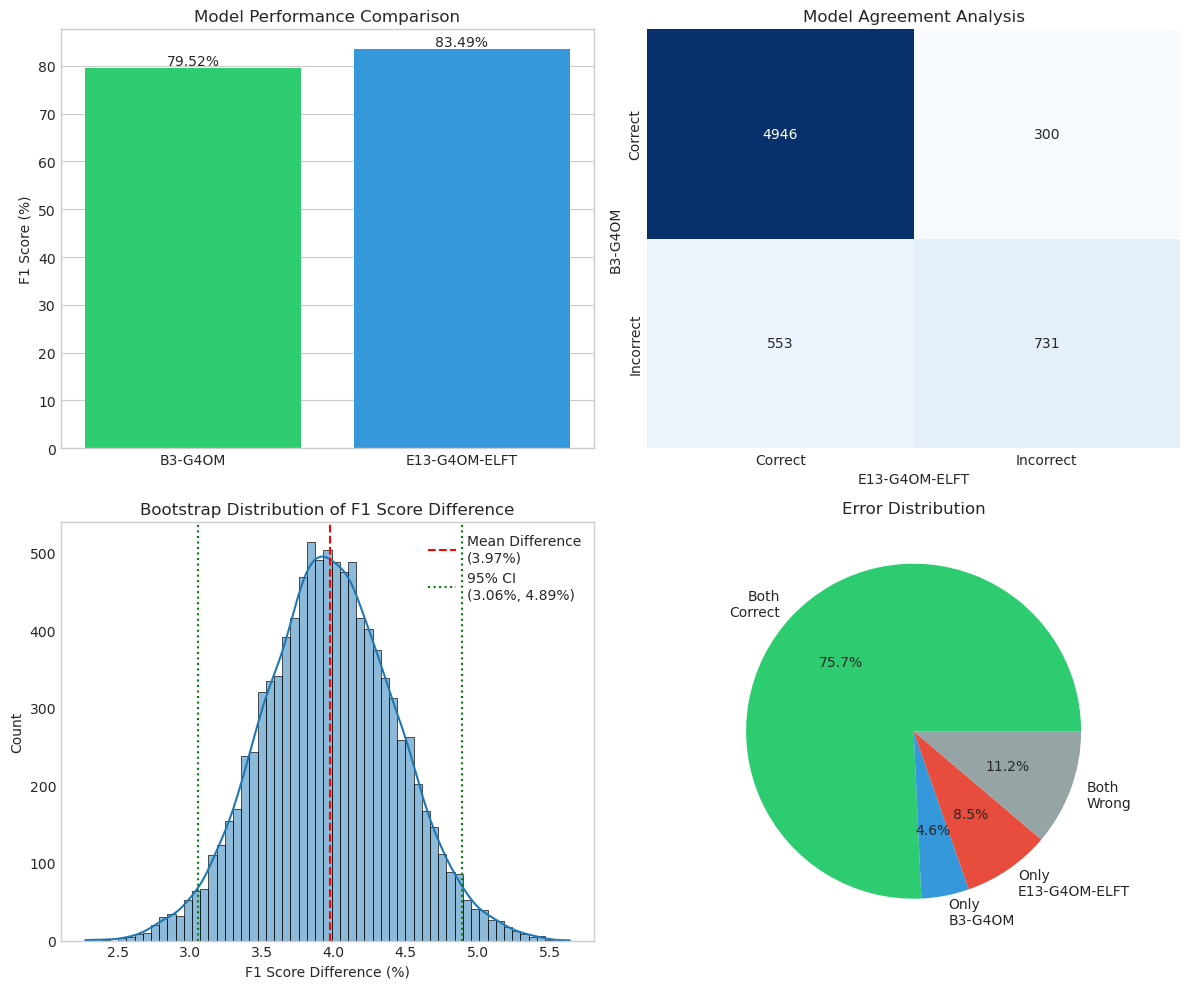


Results Summary:
----------------------------------------
F1 Score B3-G4OM: 79.52%
F1 Score E13-G4OM-ELFT: 83.49%
Difference: +3.97%
95% CI: (3.06%, 4.89%)
McNemar's test p-value: 0.0000
Bootstrap test p-value: 0.0000

Statistical Analysis Results

Performance Comparison:
E13-G4OM-ELFT significantly outperformed B3-G4OM with an F1 score of 83.49% compared to 79.52%, a difference of 3.97 percentage points.

Statistical Significance:
This difference was statistically significant according to both McNemar's test (p < 0.001) and bootstrap analysis (p < 0.001). The 95% confidence interval for the difference was [3.06%, 4.89%].

Stability Analysis:
The results were assessed across multiple bootstrap runs (n=10000), with 
confidence interval bounds showing minimal variation (SD: 0.000066 to 
0.000127).

Methodological Details:
Statistical significance was assessed using McNemar's test for paired nominal data 
and a bootstrap analysis with 10000 iterations. The stability of the results 
was v

In [89]:
test_results = compare_experiments(
    df1=b3_g4om_results_df,
    df2=e13_g4om_elft_results_df,
    exp1_name='B3-G4OM',
    exp2_name='E13-G4OM-ELFT',
    n_bootstrap=10000,
    n_stability_runs=3,
)

## E7-G4O-ELFT vs. B4-G4O

GPT-4o with ELECTRA Large FT predictions vs. GPT-4o baseline.

In [90]:
# Load the CSV file as a dataframe: 'research/B3-G4OM_results.csv'
e7_g4o_elft_results_df = pd.read_csv('research/E7-G4O-ELFT_results.csv')

In [91]:
b4_g4o_results_df = pd.read_csv('research/B4-G4O_results.csv')


Comparing B4-G4O vs E7-G4O-ELFT
Started at: 2024-11-03 16:58:18

Running statistical analysis with stability check...
Starting stability analysis at 2024-11-03 16:58:18.743098

Testing 10000 iterations:

Run 1/3 started at 2024-11-03 16:58:18.752948


Bootstrap iterations: 100%|██████████| 10000/10000 [09:43<00:00, 17.13it/s]



Run 1 Results:
F1 Score 1: 0.8014
F1 Score 2: 0.8157
F1 Difference: +0.0144
95% CI: (0.0051, 0.0238)
McNemar's p-value: 0.0106
Bootstrap p-value: 0.0030
Run time: 0:09:44.249160

Contingency Table:
Both correct: 4822
Only Model 1 correct: 450
Only Model 2 correct: 531
Both wrong: 727

Run 2/3 started at 2024-11-03 17:08:03.002187


Bootstrap iterations: 100%|██████████| 10000/10000 [09:42<00:00, 17.17it/s]



Run 2 Results:
F1 Score 1: 0.8014
F1 Score 2: 0.8157
F1 Difference: +0.0144
95% CI: (0.0051, 0.0238)
McNemar's p-value: 0.0106
Bootstrap p-value: 0.0030
Run time: 0:09:43.072419

Contingency Table:
Both correct: 4822
Only Model 1 correct: 450
Only Model 2 correct: 531
Both wrong: 727

Run 3/3 started at 2024-11-03 17:17:46.074737


Bootstrap iterations: 100%|██████████| 10000/10000 [09:40<00:00, 17.23it/s]



Run 3 Results:
F1 Score 1: 0.8014
F1 Score 2: 0.8157
F1 Difference: +0.0144
95% CI: (0.0050, 0.0237)
McNemar's p-value: 0.0106
Bootstrap p-value: 0.0026
Run time: 0:09:40.810526

Contingency Table:
Both correct: 4822
Only Model 1 correct: 450
Only Model 2 correct: 531
Both wrong: 727

Generating report...

Creating visualizations...


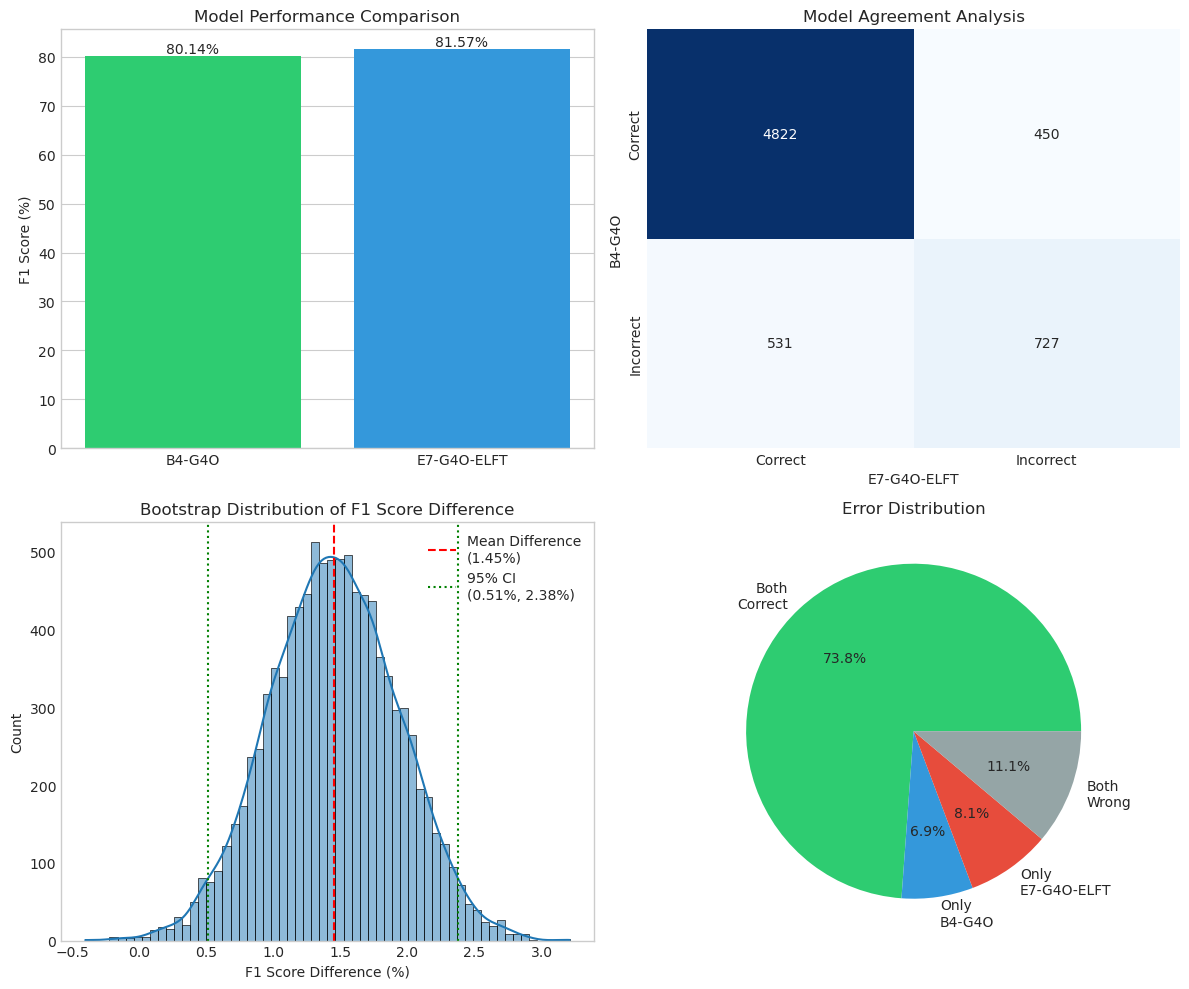


Results Summary:
----------------------------------------
F1 Score B4-G4O: 80.14%
F1 Score E7-G4O-ELFT: 81.57%
Difference: +1.44%
95% CI: (0.51%, 2.38%)
McNemar's test p-value: 0.0106
Bootstrap test p-value: 0.0030

Statistical Analysis Results

Performance Comparison:
E7-G4O-ELFT significantly outperformed B4-G4O with an F1 score of 81.57% compared to 80.14%, a difference of 1.44 percentage points.

Statistical Significance:
This difference was statistically significant according to both McNemar's test (p = 0.011) and bootstrap analysis (p = 0.003). The 95% confidence interval for the difference was [0.51%, 2.38%].

Stability Analysis:
The results were assessed across multiple bootstrap runs (n=10000), with 
confidence interval bounds showing minimal variation (SD: 0.000027 to 
0.000036).

Methodological Details:
Statistical significance was assessed using McNemar's test for paired nominal data 
and a bootstrap analysis with 10000 iterations. The stability of the results 
was verifie

In [92]:
e7_b4_results = compare_experiments(
    df1=b4_g4o_results_df,
    df2=e7_g4o_elft_results_df,
    exp1_name='B4-G4O',
    exp2_name='E7-G4O-ELFT',
    n_bootstrap=10000,
    n_stability_runs=3,
)